# <font color='red'> __-> EXPLIQUER CE QUE L'ON CHERCHE A PREDIRE, INTERET DE LA PROBLEMATIQUE, ETC__</font>

# Objectifs et motivations

Dans ce notebook, nous allons créer nos premiers modèles explicatifs afin de d'obtenir une baseline avant de procéder à une étape de création de nouvelles variables. La comparaison des résultats obtenus à l'aide de ces modèles reposant sur l'exploitation brute des attributs de la base et ceux obtenus à l'aide de nouvelle features nous permettra d'évaluer l'intérêt et la pertinance de ces features.  
  
Rappellons que notre objectif est de prédire le temps d'un match de tennis à partir des données historiques des matchs joué entre 2010 et 2019. Répondre à cette problématique aiderait les organisateurs de ces tournois à mieux agencer les matchs, l'un des principaux soucis de l'organisation de ces évènements.  

In [26]:
import os 
import string
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [27]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [28]:
pd.set_option('display.max_columns', 500)
sns.set_style("ticks")

In [29]:
def perc_print(a, b):
    return round((a-b)/a*100)

In [30]:
PATH = os.path.abspath('')

## <font color='red'>__-> Retraitement des données -> Sauvegarder notre base une fois cette opération faite dans Features engineering__</font>

REMARQUE : On ne se base pas sur la table avec player / opponnent

In [32]:
data = pd.read_csv(PATH+'/data/Données_nettoyées.csv', index_col=0, low_memory=False)

# Modèles de base

Nous allons présenter dans ce notebook une première série de modèles basés sur l'exploitation des attributs contenus dans notre base de données afin d'analyser les résultats obtenus par ce biais avant de complexifier le modèle en procédant à une phase de création de features.  
Ces résultats serviront de baseline par la suite afin de juger de la qualité des modèles qui le suivront. La mesure de qualité du modèle choisi sera la Mean Squared Error (MSE).  

La plupart de nos variables sont des statistiques concernant directement le match et ne sont donc pas utilisables dans le cadre d'une prédiction. Ces variables devront être aggrégés avant d'être utilisable pour caractériser un joueur. 
  
Les différentes opérations effectuées sont :
- Création d'une base d'appprentissage et de validation et séparation des attributs du phénomène à expliquer
- Traitement des variables catégorielles
- Régression Linéaire
- Régression Lasso
- Régression Polynomiale (déjà une création de features... à voir)
- Arbre de Décisions
- Random Forest
- Adaboost

## Création d'une base d'appprentissage et de validation et séparation des attributs du phénomène à expliquer

La base d'apprentissage et de validation est crée à l'aide de la fonction `train_test_split`. Nous prenons 1/3 de notre échantillon pour construire la base de validation.

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('minutes', axis=1), data['minutes'], test_size=0.33, random_state=42)
print("Taille de l'échantillon d'apprentissage : {}\nTaille de l'échantillon de validation : {}".format(X_train.shape[0], X_test.shape[0]))

Taille de l'échantillon d'apprentissage : 34787
Taille de l'échantillon de validation : 17135


Deux types d'attributs sont supprimés :
1. les attributs directement liées au match (w_ace le nombre d'ace du gagnant, l_bpSaved le nombre de balles de match sauvées par le perdant, etc...)
2. les attributs d'identification (tourney_id, winner_id, etc...)

Seuls sont gardés les attributs n'étant pas directement liée au match et ayant un potentiel.

In [35]:
print("Nombre d'attributs initiaux : {}".format(X_train.shape[1]))

Nombre d'attributs initiaux : 49


In [36]:
liste_attributs = ['tourney_name', 
                   'tourney_level',
                   'surface',
                   'winner_hand',
                   'winner_ht', 
                   'winner_age',
                   'winner_rank',
                   'loser_hand', 
                   'loser_ht', 
                   'loser_age',
                   'loser_rank',
                   'best_of',
                   'round',
                   'year']

In [37]:
X_train , X_test = X_train[liste_attributs] , X_test[liste_attributs]
print("Nombre d'attributs après sélection : {}".format(X_train.shape[1]))

Nombre d'attributs après sélection : 14


## Traitement des variables catégorielles et supression des valeurs manquantes

Nous commençons par répérer les variables catégorielles avant d'observer le nombre de modalitées qu'elles prennent.

In [38]:
X_qual = ['tourney_name', 'surface', 'tourney_level', 'round', 'winner_hand', 'loser_hand']
for attribut in X_qual:
    print(attribut, ':', pd.get_dummies(data[attribut]).shape[1])

tourney_name : 126
surface : 4
tourney_level : 4
round : 10
winner_hand : 3
loser_hand : 3


L'attribut _tourney_name_ prend 126 modalités. La matrice étant trop sparse nous l'ignorons pour le moment, et cette dernière sera ré-intégrées lors d'une régression régularisée.  
Les autres attributs qualitatifs seront retraités de manière à ce que chaque modalité soit encodée par une dummy, en prenant garde au problème de multicolinéarité en utilisant l'option `drop_first=True` de la fonction `get_dummies`.

In [39]:
X_qual.remove('tourney_name')
X_train_LM = X_train.drop('tourney_name', axis=1)
X_test_LM = X_test.drop('tourney_name', axis=1)

In [40]:
for X in [X_train_LM, X_test_LM]:
    for variable in X_qual:
        var_enc = pd.get_dummies(X[variable], prefix=variable, drop_first=True)
        X.drop(variable, axis=1, inplace=True)
        for col_enc in var_enc.columns:
            X[col_enc] = var_enc[col_enc]

Finalement, nous supprimons les variables manques.

In [41]:
for attribut in X_train_LM.columns:
    print('{} : test = {} NA / train = {} NA'.format(attribut, X_train_LM[attribut].isna().sum(), X_test_LM[attribut].isna().sum()))

winner_ht : test = 1950 NA / train = 948 NA
winner_age : test = 0 NA / train = 0 NA
winner_rank : test = 13 NA / train = 8 NA
loser_ht : test = 2990 NA / train = 1546 NA
loser_age : test = 0 NA / train = 0 NA
loser_rank : test = 85 NA / train = 44 NA
best_of : test = 0 NA / train = 0 NA
year : test = 0 NA / train = 0 NA
surface_Clay : test = 0 NA / train = 0 NA
surface_Grass : test = 0 NA / train = 0 NA
surface_Hard : test = 0 NA / train = 0 NA
tourney_level_F : test = 0 NA / train = 0 NA
tourney_level_G : test = 0 NA / train = 0 NA
tourney_level_M : test = 0 NA / train = 0 NA
round_ER : test = 0 NA / train = 0 NA
round_F : test = 0 NA / train = 0 NA
round_QF : test = 0 NA / train = 0 NA
round_R128 : test = 0 NA / train = 0 NA
round_R16 : test = 0 NA / train = 0 NA
round_R32 : test = 0 NA / train = 0 NA
round_R64 : test = 0 NA / train = 0 NA
round_RR : test = 0 NA / train = 0 NA
round_SF : test = 0 NA / train = 0 NA
winner_hand_R : test = 0 NA / train = 0 NA
winner_hand_U : test = 0 NA

Les attributs _winner_ht_ et _loser_ht_ ayant trop de valeurs manquantes, nous supprimons ces deux colonnes et retirons les observations contenant d'autres valeurs manquantes sur les autres attributs.

In [42]:
X_train_LM = X_train_LM.drop(['winner_ht', 'loser_ht'], axis=1)
X_test_LM = X_test_LM.drop(['winner_ht', 'loser_ht'], axis=1)

In [43]:
X_train_LM.dropna(axis=0, how='any', inplace=True)
X_test_LM.dropna(axis=0, how='any', inplace=True)
y_train = y_train[X_train_LM.index]
y_test = y_test[X_test_LM.index]

## Régression Linéaire

Nous utilisons finalement la fonction `LinearRegression` en notant que l'intercept est mise par défaut par la fonction (et la gestion de la multicolinéarité est égaelement gérée par défaut par la fonction).  
Nous importons également la fonction `mean_squared_error` afin de calculer la MSE.

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Entrainement du modèle.

In [19]:
regLM = LinearRegression().fit(X_train_LM.values, y_train.values)

Notre échantillon de validation ne contenant pas de modalité _round_ER_ nous la créons de manière artificielle (`np.zeros`) afin d'avoir le format requis pour prédire en utilisant notre modèle _regLM_.

In [20]:
y_pred_train = regLM.predict(X_train_LM.values)
y_pred_test = regLM.predict(X_test_LM.values)
print('MSE : train = {} / test = {}'.format(mean_squared_error(y_train.values, y_pred_train), mean_squared_error(y_test.values, y_pred_test)))

MSE : train = 1079.9669999686564 / test = 1101.4971213437143


In [21]:
coefficients = pd.concat([pd.DataFrame(X_train_LM.columns),pd.DataFrame(np.transpose(regLM.coef_))], axis = 1)
coefficients

,0,0
0,winner_age,0.160540
1,winner_rank,0.036079
2,loser_age,0.067154
3,loser_rank,-0.024167
4,best_of,27.505000
5,year,0.415295
6,surface_Clay,4.579903
7,surface_Grass,-4.465935
8,surface_Hard,0.939231
9,tourney_level_F,8.419111


Une analyse rapide des coefficients de nos variables explicatives nous montre clairement le faible pouvoir explicatif de la durée d'un match de la plupart de nos variables.

### <font color='red'>__-> Interprétation à faire__</font>

On voit que la variable _best_of_ joue un rôle prépondérant dans la détermination de la longueur d'un match, comme nous pouvions nous y attendre.  
  
L'utilisation de cette variable ajoute une grand part d'explicativité dans notre modèle mais cependant, une visialisation de nos résultats nous montre clairement deux catégories de match se distinguer. L'intuition nous amène a penser que ces deux clusters sont uniquement défini par l'attribut _best_of_, ce que nous vérifions sur nos deux échantillons.

In [22]:
X_train_LM_bo3 = X_train_LM[X_train_LM['best_of']==3].copy()
X_train_LM_bo5 = X_train_LM[X_train_LM['best_of']==5].copy()
y_train_bo3 = y_train[X_train_LM_bo3.index]
y_train_bo5 = y_train[X_train_LM_bo5.index]
X_test_LM_bo3 = X_test_LM[X_test_LM['best_of']==3].copy()
X_test_LM_bo5 = X_test_LM[X_test_LM['best_of']==5].copy()
y_test_bo3 = y_test[X_test_LM_bo3.index]
y_test_bo5 = y_test[X_test_LM_bo5.index]

In [23]:
y_pred_train_bo3 = regLM.predict(X_train_LM_bo3.values)
y_pred_train_bo5 = regLM.predict(X_train_LM_bo5.values)
y_pred_test_bo3 = regLM.predict(X_test_LM_bo3.values)
y_pred_test_bo5 = regLM.predict(X_test_LM_bo5.values)

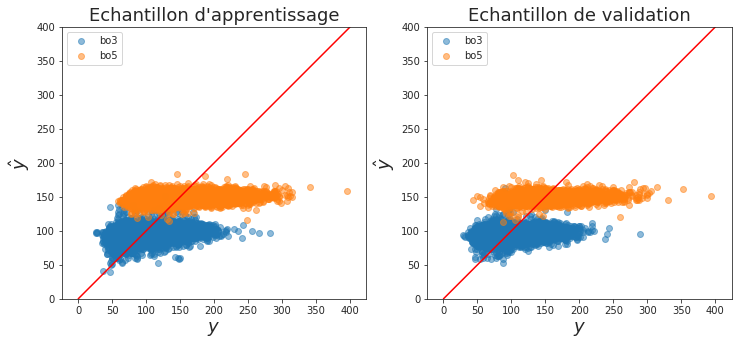

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].scatter(y_train_bo3.values, y_pred_train_bo3, alpha=0.5, label='bo3')
axs[0].scatter(y_train_bo5.values, y_pred_train_bo5, alpha=0.5, label='bo5')
axs[0].plot([0,400], [0,400], color='red')
axs[0].axis('equal')
axs[0].set_xlim((0,400))
axs[0].set_ylim((0,400))
axs[0].set_xlabel("$y$",fontsize=18)
axs[0].set_ylabel("$\hat{y}$",fontsize=18)
axs[0].legend()
axs[0].set_title("Echantillon d'apprentissage",fontsize=18)
axs[1].scatter(y_test_bo3.values, y_pred_test_bo3, alpha=0.5, label='bo3')
axs[1].scatter(y_test_bo5.values, y_pred_test_bo5, alpha=0.5, label='bo5')
axs[1].plot([0,400], [0,400], color='red')
axs[1].axis('equal')
axs[1].set_xlim((0,400))
axs[1].set_ylim((0,400))
axs[1].set_xlabel("$y$",fontsize=18)
axs[1].set_ylabel("$\hat{y}$",fontsize=18)
axs[1].legend()
axs[1].set_title("Echantillon de validation", fontsize=18)
plt.show()

A partir de ce résultat, nous décidons créer des modèles spécifiques aux Bo3 et aux Bo5. Ces résultats serviront de baseline par la suite.

In [25]:
X_train_LM_bo3.drop('best_of', axis=1, inplace=True)
X_train_LM_bo5.drop('best_of', axis=1, inplace=True)
X_test_LM_bo3.drop('best_of', axis=1, inplace=True)
X_test_LM_bo5.drop('best_of', axis=1, inplace=True)

In [26]:
regLM_bo3 = LinearRegression().fit(X_train_LM_bo3.values, y_train_bo3.values)

y_pred_train_bo3 = regLM_bo3.predict(X_train_LM_bo3.values)
y_pred_test_bo3 = regLM_bo3.predict(X_test_LM_bo3.values)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo3.values, y_pred_train_bo3),
                                                    mean_squared_error(y_test_bo3.values, y_pred_test_bo3)))

regLM_bo5 = LinearRegression().fit(X_train_LM_bo5.values, y_train_bo5.values)

y_pred_train_bo5 = regLM_bo5.predict(X_train_LM_bo5.values)
y_pred_test_bo5 = regLM_bo5.predict(X_test_LM_bo5.values)
print('Bo5:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo5.values, y_pred_train_bo5),
                                                    mean_squared_error(y_test_bo5.values, y_pred_test_bo5)))

Bo3:
	MSE : train = 869.0569518785819 / test = 885.3315597134199
Bo5:
	MSE : train = 1976.3922892299145 / test = 2052.465230766853


Nous utilisons `statsmodels` afin d'analyser la statistique de Jarque-Bera qui nous indique si les erreures de notre modèle sont normales.

In [27]:
from statsmodels.formula.api import ols
from statsmodels.tools.tools import add_constant
modele = ols('minutes ~ const + C(surface) + C(tourney_level) + C(winner_hand)+ winner_age + winner_rank + winner_age \
          + C(loser_hand) + loser_age + loser_rank + loser_age + C(round) + year', 
             data=add_constant(data)[data['best_of']==3])
resultat = modele.fit()

In [28]:
print(resultat.summary())

                            OLS Regression Results                            
Dep. Variable:                minutes   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     60.40
Date:                Thu, 30 Jan 2020   Prob (F-statistic):          6.99e-275
Time:                        19:27:37   Log-Likelihood:            -2.0288e+05
No. Observations:               42217   AIC:                         4.058e+05
Df Residuals:                   42193   BIC:                         4.060e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              -333.15

Le test de Jarque-Bera rejette l'hypothèse de normalité des résidus.  

## Régression Lasso (Least Absolute Shrinkage and Selection Operator)

Afin de réaliser une sélection parcimonieuse de nos variables, nous effectuons une régression Lasso, qui, contrairement à la régression Ridge, permet d'assigner la valeur des coefficients exactement à zéro, et ainsi éliminer les variables non pertinentes.

In [29]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [30]:
regLasso = Lasso(max_iter=100000, tol=0.1)

La régression Lasso comprend un coefficient de pénalité $\alpha$ qu'il est nécessaire d'optimiser par cross-validation. Pour ce faire, nous utilisons la fonction `GridSearchCV` sur le vecteur de valeurs à tester de $\alpha$ _lasso_params_. Une fois encore, la métrique utilisée reste la MSE (_neg_mean_squared_error_ pour être précis dans le cadre d'une optimisation).

In [31]:
lasso_params = {'alpha':[1e-15, 1e-10, 1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10]}

In [32]:
GSCV_lasso_bo3 = GridSearchCV(regLasso, lasso_params, 'neg_mean_squared_error', cv=3)

In [33]:
GSCV_lasso_bo3.fit(X_train_LM_bo3, y_train_bo3)

/home/cesar/.anaconda3/envs/projetml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8170951.535045076, tolerance: 1695310.5004777578
  positive)
/home/cesar/.anaconda3/envs/projetml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8115157.106565085, tolerance: 1680856.9074685497
  positive)


GridSearchCV(cv=3, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=100000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.1, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 1e-05, 0.0001, 0.001,
                                   0.01, 0.1, 1, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

<font color='red'>Malgrès l'augmentation de la tolérence du modèle et du nombre d'itérations effectuées, la convergence de notre modèle n'est pas atteinte pour les faibles valeurs de $\alpha = \{10^{-15}, 10^{-10}\}$.</font>

In [34]:
regBestLasso_bo3 = GSCV_lasso_bo3.best_estimator_
print('Valeur optimale de alpha : {}'.format(regBestLasso_bo3.get_params()['alpha']))

Valeur optimale de alpha : 0.01


In [35]:
y_pred_train_bo3 = regBestLasso_bo3.predict(X_train_LM_bo3.values)
y_pred_test_bo3 = regBestLasso_bo3.predict(X_test_LM_bo3.values)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo3.values, y_pred_train_bo3),
                                                    mean_squared_error(y_test_bo3.values, y_pred_test_bo3)))

Bo3:
	MSE : train = 869.2434707540339 / test = 884.98975176799


In [36]:
GSCV_lasso_bo5 = GridSearchCV(regLasso, lasso_params, 'neg_mean_squared_error', cv=3)
GSCV_lasso_bo5.fit(X_train_LM_bo5, y_train_bo5)
regBestLasso_bo5 = GSCV_lasso_bo5.best_estimator_
print('Valeur optimale de alpha : {}'.format(regBestLasso_bo5.get_params()['alpha']))
y_pred_train_bo5 = regBestLasso_bo5.predict(X_train_LM_bo5.values)
y_pred_test_bo5 = regBestLasso_bo5.predict(X_test_LM_bo5.values)
print('Bo5:\n\tMSE : test = {} / train = {}'.format(mean_squared_error(y_train_bo5.values, y_pred_train_bo5),
                                                    mean_squared_error(y_test_bo5.values, y_pred_test_bo5)))

/home/cesar/.anaconda3/envs/projetml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4209336.984767436, tolerance: 908380.170095638
  positive)
/home/cesar/.anaconda3/envs/projetml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3998142.732592154, tolerance: 868063.4106110074
  positive)
/home/cesar/.anaconda3/envs/projetml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1870553.356595695, tolerance: 868063.4106110074
  positive)
/home/cesar/.anaconda3/envs/projetml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Obj

Valeur optimale de alpha : 0.1
Bo5:
	MSE : test = 1980.9348890316226 / train = 2052.499125577999


la valeur optimale trouvée par validation croisée sur notre base d'apprentissage est :
- $\alpha=0.01$ pour les Bo3
- $\alpha=0.1$ pour les Bo5

Nous procédons à partir de ces résultats à une seconde GridSearch plus fine centrée autour de ces valeurs. 

In [ ]:
lasso_params_centre_bo3 = {'alpha':[0.01-(x*0.001) for x in range(-10, 10)]}
lasso_params_centre_bo5 = {'alpha':[0.1-(x*0.01) for x in range(-10, 10)]}

In [38]:
GSCV_lasso_bo3 = GridSearchCV(regLasso, lasso_params_centre_bo3, 'neg_mean_squared_error', cv=3)
GSCV_lasso_bo3.fit(X_train_LM_bo3, y_train_bo3)
regBestLasso_bo3 = GSCV_lasso_bo3.best_estimator_
print('Valeur optimale de alpha : {}'.format(regBestLasso_bo3.get_params()['alpha']))
y_pred_train_bo3 = regBestLasso_bo3.predict(X_train_LM_bo3.values)
y_pred_test_bo3 = regBestLasso_bo3.predict(X_test_LM_bo3.values)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo3.values, y_pred_train_bo3),
                                                    mean_squared_error(y_test_bo3.values, y_pred_test_bo3)))

GSCV_lasso_bo5 = GridSearchCV(regLasso, lasso_params_centre_bo5, 'neg_mean_squared_error', cv=3)
GSCV_lasso_bo5.fit(X_train_LM_bo5, y_train_bo5)
regBestLasso_bo5 = GSCV_lasso_bo5.best_estimator_
print('Valeur optimale de alpha : {}'.format(regBestLasso_bo5.get_params()['alpha']))
y_pred_train_bo5 = regBestLasso_bo5.predict(X_train_LM_bo5.values)
y_pred_test_bo5 = regBestLasso_bo5.predict(X_test_LM_bo5.values)
print('Bo5:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo5.values, y_pred_train_bo5),
                                                    mean_squared_error(y_test_bo5.values, y_pred_test_bo5)))

Valeur optimale de alpha : 0.005
Bo3:
	MSE : test = 869.1077335529666 / train = 885.1301115725183
Valeur optimale de alpha : 0.04000000000000001
Bo5:
	MSE : test = 1979.04601438568 / train = 2049.294273366388


Nous gardons à partir d'ici ces valeurs pour nos coefficients de pénalisation: 
- $\alpha_{Bo3}^*=0.005$
- $\alpha_{Bo5}^*=0.04$

In [39]:
regLasso_bo3 = Lasso(alpha=0.005, max_iter=100000, tol=0.01).fit(X_train_LM_bo3, y_train_bo3)
regLasso_bo5 = Lasso(alpha=0.04, max_iter=100000, tol=0.01).fit(X_train_LM_bo5, y_train_bo5)

Analyse des coefficients éliminés par la régularisation L1 pour le modèle bo3.

In [40]:
print('Coeffcients retenus dans le modèle Bo3:\n')
for var, coef in zip(X_train_LM_bo3.columns, regLasso_bo3.coef_):
    if coef != 0:
        print('Coefficient {} = {}'.format(var, coef))
print('\nCoeffcients éliminés dans le modèle Bo3:\n')
for var, coef in zip(X_train_LM_bo3.columns, regLasso_bo3.coef_):
    if coef == 0:
        print('Coefficient {} = {}'.format(var, coef))

Coeffcients retenus dans le modèle Bo3:

Coefficient winner_age = 0.15196250509528048
Coefficient winner_rank = 0.02525419360705143
Coefficient loser_age = 0.01592489956188355
Coefficient loser_rank = -0.020896499698423124
Coefficient year = 0.40391861556788256
Coefficient surface_Clay = 4.522310535170495
Coefficient surface_Grass = -3.971845993815142
Coefficient surface_Hard = 0.25918167087846533
Coefficient tourney_level_F = 8.695523308235629
Coefficient tourney_level_M = 4.28557627802395
Coefficient round_ER = -8.032265353617346
Coefficient round_F = 8.362350489841829
Coefficient round_QF = 3.337485944610628
Coefficient round_R128 = -1.8834773359128787
Coefficient round_R16 = 1.3133163144500781
Coefficient round_R32 = -0.8494587980668702
Coefficient round_R64 = -2.373739566999927
Coefficient round_SF = 4.921759774398725
Coefficient winner_hand_R = -0.5581254464721479
Coefficient loser_hand_R = 0.9972444471599353
Coefficient loser_hand_U = -0.3930198924078167

Coeffcients éliminés da

Analyse des coefficients éliminés par la régularisation L1 pour le modèle bo5.

In [41]:
print('Coeffcients retenus dans le modèle Bo5:\n')
for var, coef in zip(X_train_LM_bo5.columns, regLasso_bo5.coef_):
    if coef != 0:
        print('Coefficient {} = {}'.format(var, coef))
print('\nCoeffcients éliminés dans le modèle Bo5:\n')
for var, coef in zip(X_train_LM_bo5.columns, regLasso_bo5.coef_):
    if coef == 0:
        print('Coefficient {} = {}'.format(var, coef))

Coeffcients retenus dans le modèle Bo5:

Coefficient winner_age = 0.18970815233305766
Coefficient winner_rank = 0.09443372165174208
Coefficient loser_age = 0.26679568615253757
Coefficient loser_rank = -0.048959463445284984
Coefficient year = 0.5078072948394142
Coefficient surface_Clay = 1.9146478226509513
Coefficient surface_Grass = -6.96513886930673
Coefficient surface_Hard = 0.7718288232380786
Coefficient round_F = 9.218515739412345
Coefficient round_QF = 2.3234918030923253
Coefficient round_R128 = -9.41303996886615
Coefficient round_R32 = -3.551358396882016
Coefficient round_R64 = -5.645515415933908
Coefficient round_SF = 10.3703419429913
Coefficient winner_hand_R = -1.9887223781486345
Coefficient loser_hand_R = 2.8771909278599472

Coeffcients éliminés dans le modèle Bo5:

Coefficient tourney_level_F = -0.0
Coefficient tourney_level_G = 0.0
Coefficient tourney_level_M = -0.0
Coefficient round_ER = 0.0
Coefficient round_R16 = 0.0
Coefficient round_RR = 0.0
Coefficient winner_hand_U =

Le coefficient de pénalisation $\alpha$ étant plus élevé dans le modèle Bo5, plus de variables sont éliminées, cependant, nous retrouvons des concordances dans la liste des variables éliminés : les variables _round_RR_, _tourney_level_G_ et _winner_hand_U_ sont éliminés dans les deux modèles.
  
Le modèle bo5 élimine un plus grand nombre de variables, et parmis ces variables contraites à zéro, nous remarquons que chaque modalité de la variable _tourney_level_ sont mises à zéro, témoignant du faible pouvoir explicatif de cet attribut dans un Bo5.
  
Nous retirons donc cet attribut dans notre base Bo5. <font color='red'>Et d'autres / regrouper des modalités?</font>

In [42]:
X_train_LM_bo5.drop(['tourney_level_M', 'tourney_level_G', 'tourney_level_F'], axis=1, inplace=True)

Maintenant que nous avons fixé la valeur de $\alpha$ nous réintégrons la variable _tourney_name_ pour voir les modalités (nom du tournoi) comportant un pouvoir explicatif.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('minutes', axis=1), data['minutes'], test_size=0.33, random_state=42)
X_train , X_test = X_train[liste_attributs] , X_test[liste_attributs]

X_train_LM = X_train.copy()
X_test_LM = X_test.copy()

# Cette fois nous laissons tourney_name dans X_qual
X_qual = ['tourney_name', 'surface', 'tourney_level', 'round', 'winner_hand', 'loser_hand']
for X in [X_train_LM, X_test_LM]:
    for variable in X_qual:
        var_enc = pd.get_dummies(X[variable], prefix=variable, drop_first=True)
        X.drop(variable, axis=1, inplace=True)
        for col_enc in var_enc.columns:
            X[col_enc] = var_enc[col_enc]
X_train_LM = X_train_LM.drop(['winner_ht', 'loser_ht'], axis=1)
X_test_LM = X_test_LM.drop(['winner_ht', 'loser_ht'], axis=1)

X_train_LM.dropna(axis=0, how='any', inplace=True)
X_test_LM.dropna(axis=0, how='any', inplace=True)
y_train = y_train[X_train_LM.index]
y_test = y_test[X_test_LM.index]

X_train_LM_bo3 = X_train_LM[X_train_LM['best_of']==3].copy()
X_train_LM_bo5 = X_train_LM[X_train_LM['best_of']==5].copy()
y_train_bo3 = y_train[X_train_LM_bo3.index]
y_train_bo5 = y_train[X_train_LM_bo5.index]
X_test_LM_bo3 = X_test_LM[X_test_LM['best_of']==3].copy()
X_test_LM_bo5 = X_test_LM[X_test_LM['best_of']==5].copy()
y_test_bo3 = y_test[X_test_LM_bo3.index]
y_test_bo5 = y_test[X_test_LM_bo5.index]

X_train_LM_bo3.drop('best_of', axis=1, inplace=True)
X_train_LM_bo5.drop('best_of', axis=1, inplace=True)
X_test_LM_bo3.drop('best_of', axis=1, inplace=True)
X_test_LM_bo5.drop('best_of', axis=1, inplace=True)

X_train_LM_bo5.drop(['tourney_level_M', 'tourney_level_G', 'tourney_level_F'], axis=1, inplace=True)

In [44]:
regLasso_bo3 = Lasso(alpha=0.005, max_iter=100000, tol=0.1).fit(X_train_LM_bo3, y_train_bo3)
regLasso_bo5 = Lasso(alpha=0.04, max_iter=100000, tol=0.1).fit(X_train_LM_bo5, y_train_bo5)

In [45]:
tournois_retenus_bo3 = []
print('Tournois retenus dans le modèle Bo3:\n')
for var, coef in zip(X_train_LM_bo3.columns, regLasso_bo3.coef_):
    if var[:12] == 'tourney_name':
        if coef != 0:
            print('Tournoi {} = {}'.format(var, coef))
            tournois_retenus_bo3.append(var)
print('\nTournois éliminés dans le modèle Bo3:\n')
for var, coef in zip(X_train_LM_bo3.columns, regLasso_bo3.coef_):
    if var[:12] == 'tourney_name':
        if coef == 0:
            print('Tournoi {} = {}'.format(var, coef))

Tournois retenus dans le modèle Bo3:

Tournoi tourney_name_Acapulco = 2.8559036758554557
Tournoi tourney_name_Adelaide = -2.06365052801325
Tournoi tourney_name_Amersfoort = -0.7842327311423031
Tournoi tourney_name_Amsterdam = -3.403558155174098
Tournoi tourney_name_Antalya = 2.2309324670189876
Tournoi tourney_name_Atlanta = 1.614994135764263
Tournoi tourney_name_Auckland = -3.5429944696779736
Tournoi tourney_name_Barcelona = 2.751909657776693
Tournoi tourney_name_Basel = -1.0570806527359309
Tournoi tourney_name_Bastad = -3.7599824245855946
Tournoi tourney_name_Beijing Olympics = 3.6546093402155466
Tournoi tourney_name_Belgrade = 5.162620719043362
Tournoi tourney_name_Bogota = -6.41681887696037
Tournoi tourney_name_Brighton = -6.720926023352626
Tournoi tourney_name_Bucharest = 2.586466220270424
Tournoi tourney_name_Budapest = -1.899913691666687
Tournoi tourney_name_Buenos Aires = 2.4419516310255878
Tournoi tourney_name_Canada Masters = 3.311778850967685
Tournoi tourney_name_Casablanca =

In [46]:
tournois_retenus_bo5 = []
print('Tournois retenus dans le modèle Bo5:\n')
for var, coef in zip(X_train_LM_bo5.columns, regLasso_bo5.coef_):
    if var[:12] == 'tourney_name':
        if coef != 0:
            print('Tournoi {} = {}'.format(var, coef))
            tournois_retenus_bo5.append(var)
print('\nTournois éliminés dans le modèle Bo5:\n')
for var, coef in zip(X_train_LM_bo5.columns, regLasso_bo5.coef_):
    if var[:12] == 'tourney_name':
        if coef == 0:
            print('Tournoi {} = {}'.format(var, coef))

Tournois retenus dans le modèle Bo5:

Tournoi tourney_name_Australian Open = 1.7454627765738358
Tournoi tourney_name_Roland Garros = 1.73881188921559
Tournoi tourney_name_US Open = 2.290210653129444
Tournoi tourney_name_Wimbledon = -5.8157526575403775

Tournois éliminés dans le modèle Bo5:

Tournoi tourney_name_ATP Next Gen Finals = 0.0
Tournoi tourney_name_Acapulco = 0.0
Tournoi tourney_name_Adelaide = 0.0
Tournoi tourney_name_Amersfoort = -0.0
Tournoi tourney_name_Amsterdam = 0.0
Tournoi tourney_name_Antalya = 0.0
Tournoi tourney_name_Antwerp = 0.0
Tournoi tourney_name_Atlanta = 0.0
Tournoi tourney_name_Auckland = 0.0
Tournoi tourney_name_Bangkok = 0.0
Tournoi tourney_name_Barcelona = 0.0
Tournoi tourney_name_Basel = -0.0
Tournoi tourney_name_Bastad = 0.0
Tournoi tourney_name_Beijing = 0.0
Tournoi tourney_name_Beijing Olympics = -0.0
Tournoi tourney_name_Belgrade = 0.0
Tournoi tourney_name_Bogota = 0.0
Tournoi tourney_name_Brighton = 0.0
Tournoi tourney_name_Brisbane = 0.0
Tournoi to

Nous devons également intégrer le tournoi servant de modalité de référence dans le deux régressions.

In [47]:
nom_tournois = [x for x in data['tourney_name'].unique()]
for var in X_train_LM_bo3.columns:
    if var[:12] == 'tourney_name':
        if var[13:] in nom_tournois:
            nom_tournois.remove(var[13:])
print('Modalité de référence pour la variable tournoi dans bo3: {}'.format(nom_tournois[0]))
tournois_retenus_bo3 = tournois_retenus_bo3 + nom_tournois

Modalité de référence pour la variable tournoi dans bo3: 's-Hertogenbosch


In [48]:
nom_tournois = [x for x in data['tourney_name'].unique()]
for var in X_train_LM_bo5.columns:
    if var[:12] == 'tourney_name':
        if var[13:] in nom_tournois:
            nom_tournois.remove(var[13:])
print('Modalité de référence pour la variable tournoi dans bo5: {}'.format(nom_tournois[0]))
tournois_retenus_bo5 = tournois_retenus_bo5 + nom_tournois

Modalité de référence pour la variable tournoi dans bo5: 's-Hertogenbosch


Nous recodons notre variable catégorielle _tourney_name_ en regroupant toutes les modalités supprimées à zéro.

In [49]:
X_train_LM = X_train.copy()
X_test_LM = X_test.copy()

X_qual = ['surface', 'tourney_level', 'round', 'winner_hand', 'loser_hand']
for X in [X_train_LM, X_test_LM]:
    for variable in X_qual:
        var_enc = pd.get_dummies(X[variable], prefix=variable, drop_first=True)
        X.drop(variable, axis=1, inplace=True)
        for col_enc in var_enc.columns:
            X[col_enc] = var_enc[col_enc]
            
X_train_LM = X_train_LM.drop(['winner_ht', 'loser_ht'], axis=1)
X_test_LM = X_test_LM.drop(['winner_ht', 'loser_ht'], axis=1)

X_train_LM.dropna(axis=0, how='any', inplace=True)
X_test_LM.dropna(axis=0, how='any', inplace=True)
y_train = y_train[X_train_LM.index]
y_test = y_test[X_test_LM.index]

X_train_LM_bo3 = X_train_LM[X_train_LM['best_of']==3].copy()
X_train_LM_bo5 = X_train_LM[X_train_LM['best_of']==5].copy()
y_train_bo3 = y_train[X_train_LM_bo3.index]
y_train_bo5 = y_train[X_train_LM_bo5.index]
X_test_LM_bo3 = X_test_LM[X_test_LM['best_of']==3].copy()
X_test_LM_bo5 = X_test_LM[X_test_LM['best_of']==5].copy()
y_test_bo3 = y_test[X_test_LM_bo3.index]
y_test_bo5 = y_test[X_test_LM_bo5.index]

X_train_LM_bo3.drop('best_of', axis=1, inplace=True)
X_train_LM_bo5.drop('best_of', axis=1, inplace=True)
X_test_LM_bo3.drop('best_of', axis=1, inplace=True)
X_test_LM_bo5.drop('best_of', axis=1, inplace=True)

X_train_LM_bo5.drop(['tourney_level_M', 'tourney_level_G', 'tourney_level_F'], axis=1, inplace=True)

In [50]:
tournois_retenus_bo3_temp = [x[13:] for x in tournois_retenus_bo3]
tournois_retenus_bo5_temp = [x[13:] for x in tournois_retenus_bo5]

In [51]:
for tournoi in tournois_retenus_bo3_temp:
    X_train_LM_bo3['tourney_name_'+tournoi] = X_train_LM_bo3.apply(lambda x: 1 if x['tourney_name']==tournoi else 0, axis=1).copy()
X_train_LM_bo3['tourney_name_autre'] = X_train_LM_bo3.apply(lambda x: 1 if x['tourney_name'] not in tournois_retenus_bo3_temp else 0, axis=1).copy()
X_train_LM_bo3.drop('tourney_name', axis=1, inplace=True)

for tournoi in tournois_retenus_bo3_temp:
    X_test_LM_bo3['tourney_name_'+tournoi] = X_test_LM_bo3.apply(lambda x: 1 if x['tourney_name']==tournoi else 0, axis=1).copy()
X_test_LM_bo3['tourney_name_autre'] = X_test_LM_bo3.apply(lambda x: 1 if x['tourney_name'] not in tournois_retenus_bo3_temp else 0, axis=1).copy()
X_test_LM_bo3.drop('tourney_name', axis=1, inplace=True)

In [52]:
for tournoi in tournois_retenus_bo5_temp:
    X_train_LM_bo5['tourney_name_'+tournoi] = X_train_LM_bo5.apply(lambda x: 1 if x['tourney_name']==tournoi else 0, axis=1).copy()
X_train_LM_bo5['tourney_name_autre'] = X_train_LM_bo5.apply(lambda x: 1 if x['tourney_name'] not in tournois_retenus_bo5_temp else 0, axis=1).copy()
X_train_LM_bo5.drop('tourney_name', axis=1, inplace=True)

for tournoi in tournois_retenus_bo5_temp:
    X_test_LM_bo5['tourney_name_'+tournoi] = X_test_LM_bo5.apply(lambda x: 1 if x['tourney_name']==tournoi else 0, axis=1).copy()
X_test_LM_bo5['tourney_name_autre'] = X_test_LM_bo5.apply(lambda x: 1 if x['tourney_name'] not in tournois_retenus_bo5_temp else 0, axis=1).copy()
X_test_LM_bo5.drop('tourney_name', axis=1, inplace=True)

## Régression Polynomiale

Une fois l'identification des tournois ayant un impact significatif sur la durée des matchs, nous utilisons une régression polynomiale sur nos features.  
  
Il est à noter que la régression polynomiale est très sensible aux outliers. Ces derniers ayant été corrigés / supprimés, nous pouvons utiliser la régression polynomiale. Nous nous limitons à une régression polynomiale de degré 2.

In [54]:
from sklearn.preprocessing import PolynomialFeatures 

In [55]:
X_poly_train_bo3 = PolynomialFeatures(degree = 2).fit_transform(X_train_LM_bo3)
X_poly_train_bo5 = PolynomialFeatures(degree = 2).fit_transform(X_train_LM_bo5)

Le nombre de features explose.

In [59]:
X_poly_train_bo3.shape, X_poly_train_bo5.shape

((28258, 7140), (6431, 406))

In [56]:
regPoly_bo3 = LinearRegression().fit(X_poly_train_bo3, y_train_bo3.values)
regPoly_bo5 = LinearRegression().fit(X_poly_train_bo5, y_train_bo5.values)

Nous commeçons par recréer les colonnes manquantes dans les datasets de test en nous assurant que l'ordre dans lequel chaque colonne apparait correspond à l'ordre des colonnes des données d'apprentissage. Nous créons une fonction effectuant cette tâche.

In [60]:
def harmonisation_train_test(df_train, df_test):
    for col in df_train.columns:
        if col not in df_test.columns:
            df_test[col] = np.zeros(df_test.shape[0])
    df_test = df_test[df_train.columns].copy()
    return df_test.copy()

In [77]:
X_test_LM_bo5 = harmonisation_train_test(X_train_LM_bo5, X_test_LM_bo5)
X_test_LM_bo3 = harmonisation_train_test(X_train_LM_bo3, X_test_LM_bo3)

In [78]:
X_poly_test_bo3 = PolynomialFeatures(degree = 2).fit_transform(X_test_LM_bo3)
X_poly_test_bo5 = PolynomialFeatures(degree = 2).fit_transform(X_test_LM_bo5)

In [79]:
y_pred_train_bo3 = regPoly_bo3.predict(X_poly_train_bo3)
y_pred_test_bo3 = regPoly_bo3.predict(X_poly_test_bo3)

In [82]:
y_pred_train_bo3 = regPoly_bo3.predict(X_poly_train_bo3)
y_pred_test_bo3 = regPoly_bo3.predict(X_poly_test_bo3)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo3.values, y_pred_train_bo3),
                                                    mean_squared_error(y_test_bo3.values, y_pred_test_bo3)))
        
y_pred_train_bo5 = regPoly_bo5.predict(X_poly_train_bo5)
y_pred_test_bo5 = regPoly_bo5.predict(X_poly_test_bo5)
print('Bo5:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo5.values, y_pred_train_bo5),
                                                    mean_squared_error(y_test_bo5.values, y_pred_test_bo5)))

Bo3:
	MSE : train = 817.0405263621401 / test = 954258.9656193512
Bo5:
	MSE : train = 1879.2607645222317 / test = 758015516.8189216


Nous pour rappel, les résultats obtenus suite à notre premier modèle linéaire était les suivants :  
  
Bo3:  
   MSE : test = 869.0569518785819 / train = 885.1216759535197  
Bo5:  
   MSE : test = 1976.3922892299145 / train = 2052.465230766853  
  
L'erreur baisse sur notre échantillon d'apprentissage mais explose sur l'échantillon test. Pour réduire le nombre de variables exploitées, nous refaisons une régression Lasso pour ne sélectionner que les variables pertinentes. 

<font color='red'>__A REVOIR__.</font>

## Arbre de décision

In [93]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz

Nous changeons de type de modèle pour passer aux arbres de décisions. Ce type de machine d'apprentissage permet la représentation d'intéraction complexe, non linéaires, entre les features exploitées, contrairement aux modèles de régression linéaire. Dans cette partie nous allons donc analyser les performances dégagés par ces derniers en les comparants aux performances des modèles linéaires.  
  
Nous reprenons les features s'étant dégagées jusqu'ici contenues dans nos bases *X_train_LM_bo3/5* et *X_test_LM_bo3/5*, et affinons les hyperparamètres du modèle par CrossValidation.

La première étape consiste à recréer nos dataframe en gardant cette fois-ci toutes les modalités d'une variabler qualitative.

In [101]:
X_train_T = X_train.copy()
X_test_T = X_test.copy()

X_qual = ['surface', 'tourney_level', 'round', 'winner_hand', 'loser_hand']
for X in [X_train_T, X_test_T]:
    for variable in X_qual:
        var_enc = pd.get_dummies(X[variable], prefix=variable, drop_first=False) # drop_first est set à False
        X.drop(variable, axis=1, inplace=True)
        for col_enc in var_enc.columns:
            X[col_enc] = var_enc[col_enc]
            
X_train_T = X_train_T.drop(['winner_ht', 'loser_ht'], axis=1)
X_test_T = X_test_T.drop(['winner_ht', 'loser_ht'], axis=1)

X_train_T.dropna(axis=0, how='any', inplace=True)
X_test_T.dropna(axis=0, how='any', inplace=True)
y_train = y_train[X_train_T.index]
y_test = y_test[X_test_T.index]

X_train_T_bo3 = X_train_T[X_train_T['best_of']==3].copy()
X_train_T_bo5 = X_train_T[X_train_T['best_of']==5].copy()
y_train_bo3 = y_train[X_train_T_bo3.index]
y_train_bo5 = y_train[X_train_T_bo5.index]
X_test_T_bo3 = X_test_T[X_test_T['best_of']==3].copy()
X_test_T_bo5 = X_test_T[X_test_T['best_of']==5].copy()
y_test_bo3 = y_test[X_test_T_bo3.index]
y_test_bo5 = y_test[X_test_T_bo5.index]

X_train_T_bo3.drop('best_of', axis=1, inplace=True)
X_train_T_bo5.drop('best_of', axis=1, inplace=True)
X_test_T_bo3.drop('best_of', axis=1, inplace=True)
X_test_T_bo5.drop('best_of', axis=1, inplace=True)

X_train_T_bo5.drop(['tourney_level_M', 'tourney_level_G', 'tourney_level_F'], axis=1, inplace=True)

for tournoi in tournois_retenus_bo3_temp:
    X_train_T_bo3['tourney_name_'+tournoi] = X_train_T_bo3.apply(lambda x: 1 if x['tourney_name']==tournoi else 0, axis=1).copy()
X_train_T_bo3['tourney_name_autre'] = X_train_T_bo3.apply(lambda x: 1 if x['tourney_name'] not in tournois_retenus_bo3_temp else 0, axis=1).copy()
X_train_T_bo3.drop('tourney_name', axis=1, inplace=True)

for tournoi in tournois_retenus_bo3_temp:
    X_test_T_bo3['tourney_name_'+tournoi] = X_test_T_bo3.apply(lambda x: 1 if x['tourney_name']==tournoi else 0, axis=1).copy()
X_test_T_bo3['tourney_name_autre'] = X_test_T_bo3.apply(lambda x: 1 if x['tourney_name'] not in tournois_retenus_bo3_temp else 0, axis=1).copy()
X_test_T_bo3.drop('tourney_name', axis=1, inplace=True)

for tournoi in tournois_retenus_bo5_temp:
    X_train_T_bo5['tourney_name_'+tournoi] = X_train_T_bo5.apply(lambda x: 1 if x['tourney_name']==tournoi else 0, axis=1).copy()
X_train_T_bo5['tourney_name_autre'] = X_train_T_bo5.apply(lambda x: 1 if x['tourney_name'] not in tournois_retenus_bo5_temp else 0, axis=1).copy()
X_train_T_bo5.drop('tourney_name', axis=1, inplace=True)

for tournoi in tournois_retenus_bo5_temp:
    X_test_T_bo5['tourney_name_'+tournoi] = X_test_T_bo5.apply(lambda x: 1 if x['tourney_name']==tournoi else 0, axis=1).copy()
X_test_T_bo5['tourney_name_autre'] = X_test_T_bo5.apply(lambda x: 1 if x['tourney_name'] not in tournois_retenus_bo5_temp else 0, axis=1).copy()
X_test_T_bo5.drop('tourney_name', axis=1, inplace=True)

Nous effectuons une GridSearch sur les paramètres _max_depth_ et _min_samples_leaf_.

In [117]:
regTree_bo3 = DecisionTreeRegressor()
regTree_bo5 = DecisionTreeRegressor()

tree_params = {'max_depth':[x for x in range(5,51,5)], 
                   'min_samples_leaf':[10, 100, 500]}

In [129]:
GSCV_Tree_bo3 = GridSearchCV(regTree_bo3, tree_params, 'neg_mean_squared_error', cv=3)
GSCV_Tree_bo3.fit(X_train_T_bo3, y_train_bo3)
regBestTree_bo3 = GSCV_Tree_bo3.best_estimator_
print('Valeur optimale de (max_depth, min_samples_leaf) : {}'.format((GSCV_Tree_bo3.best_estimator_.get_params()['max_depth'],
                                                                      GSCV_Tree_bo3.best_estimator_.get_params()['min_samples_leaf'])))
X_test_T_bo3 = harmonisation_train_test(X_train_T_bo3, X_test_T_bo3)
y_pred_train_bo3 = regBestTree_bo3.predict(X_train_T_bo3.values)
y_pred_test_bo3 = regBestTree_bo3.predict(X_test_T_bo3.values)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo3.values, y_pred_train_bo3),
                                                    mean_squared_error(y_test_bo3.values, y_pred_test_bo3)))

GSCV_Tree_bo5 = GridSearchCV(regTree_bo5, tree_params, 'neg_mean_squared_error', cv=3)
GSCV_Tree_bo5.fit(X_train_T_bo5, y_train_bo5)
regBestTree_bo5 = GSCV_Tree_bo5.best_estimator_
print('Valeur optimale de (max_depth, min_samples_leaf) : {}'.format((GSCV_Tree_bo5.best_estimator_.get_params()['max_depth'],
                                                                      GSCV_Tree_bo5.best_estimator_.get_params()['min_samples_leaf'])))
X_test_T_bo5 = harmonisation_train_test(X_train_T_bo5, X_test_T_bo5)
y_pred_train_bo5 = regBestTree_bo5.predict(X_train_T_bo5.values)
y_pred_test_bo5 = regBestTree_bo5.predict(X_test_T_bo5.values)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo5.values, y_pred_train_bo5),
                                                    mean_squared_error(y_test_bo5.values, y_pred_test_bo5)))

Valeur optimale de (max_depth, min_samples_leaf) : (5, 500)
Bo3:
	MSE : train = 864.7964840687013 / test = 887.3585179098022
Valeur optimale de (max_depth, min_samples_leaf) : (5, 100)
Bo3:
	MSE : train = 1896.4657175095374 / test = 2001.7255166094362


Les résultats obtenus sont similaires à ceux obtenus avec une régression linéaire, en notant toutefois une légère baisse de la MSE sur les match en bo5.  
  
Nous recommençons une GridSearch autour de max_depth=5.

In [130]:
regTree_bo3 = DecisionTreeRegressor(min_samples_leaf=500)
regTree_bo5 = DecisionTreeRegressor(min_samples_leaf=100)

tree_params = {'max_depth':[x for x in range(3,10)]}

In [131]:
GSCV_Tree_bo3 = GridSearchCV(regTree_bo3, tree_params, 'neg_mean_squared_error', cv=3)
GSCV_Tree_bo3.fit(X_train_T_bo3, y_train_bo3)
regBestTree_bo3 = GSCV_Tree_bo3.best_estimator_
print('Valeurs optimales de (max_depth, min_samples_leaf) : {}'.format((GSCV_Tree_bo3.best_estimator_.get_params()['max_depth'],
                                                                      GSCV_Tree_bo3.best_estimator_.get_params()['min_samples_leaf'])))
X_test_T_bo3 = harmonisation_train_test(X_train_T_bo3, X_test_T_bo3)
y_pred_train_bo3 = regBestTree_bo3.predict(X_train_T_bo3.values)
y_pred_test_bo3 = regBestTree_bo3.predict(X_test_T_bo3.values)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo3.values, y_pred_train_bo3),
                                                    mean_squared_error(y_test_bo3.values, y_pred_test_bo3)))

GSCV_Tree_bo5 = GridSearchCV(regTree_bo5, tree_params, 'neg_mean_squared_error', cv=3)
GSCV_Tree_bo5.fit(X_train_T_bo5, y_train_bo5)
regBestTree_bo5 = GSCV_Tree_bo5.best_estimator_
print('Valeurs optimales de (max_depth, min_samples_leaf) : {}'.format((GSCV_Tree_bo5.best_estimator_.get_params()['max_depth'],
                                                                      GSCV_Tree_bo5.best_estimator_.get_params()['min_samples_leaf'])))
X_test_T_bo5 = harmonisation_train_test(X_train_T_bo5, X_test_T_bo5)
y_pred_train_bo5 = regBestTree_bo5.predict(X_train_T_bo5.values)
y_pred_test_bo5 = regBestTree_bo5.predict(X_test_T_bo5.values)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo5.values, y_pred_train_bo5),
                                                    mean_squared_error(y_test_bo5.values, y_pred_test_bo5)))

Valeur optimale de (max_depth, min_samples_leaf) : (4, 500)
Bo3:
	MSE : train = 868.0901242573697 / test = 887.9643475092951
Valeur optimale de (max_depth, min_samples_leaf) : (4, 100)
Bo3:
	MSE : train = 1917.0804089004544 / test = 2002.9689068803327


La meilleure prodondeur trouvée est donc de 4 sur un seul arbre.  
Nous représentons ces deux arbres.

In [132]:
from IPython.display import Image
from sklearn.externals.six import StringIO  
import pydotplus

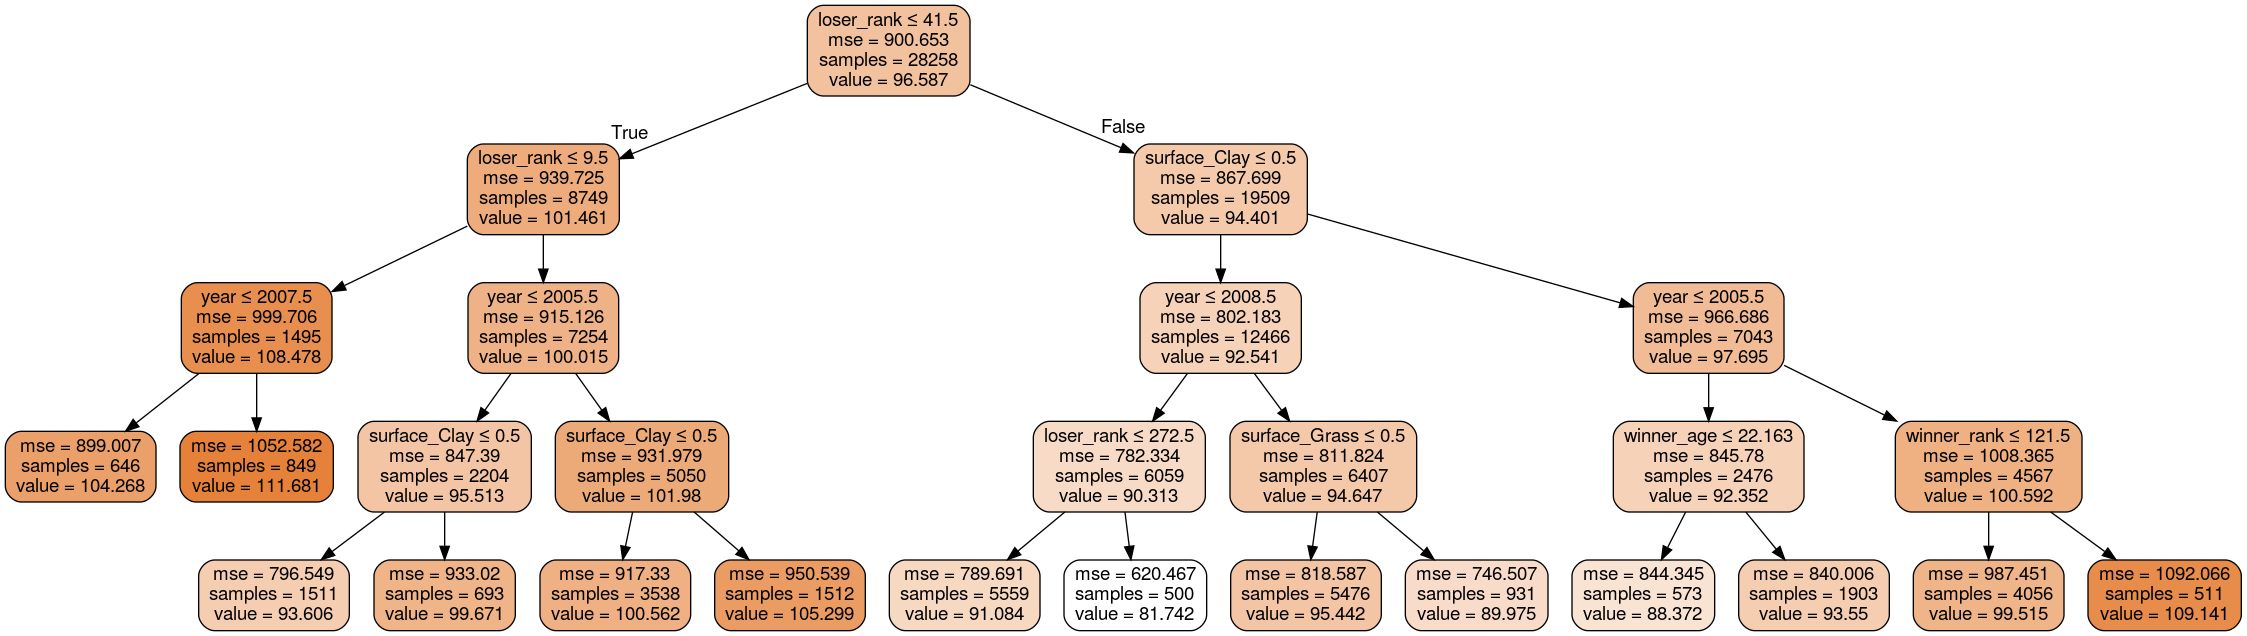

In [135]:
dot_data = StringIO()

export_graphviz(regBestTree_bo3, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
               feature_names=X_train_T_bo3.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

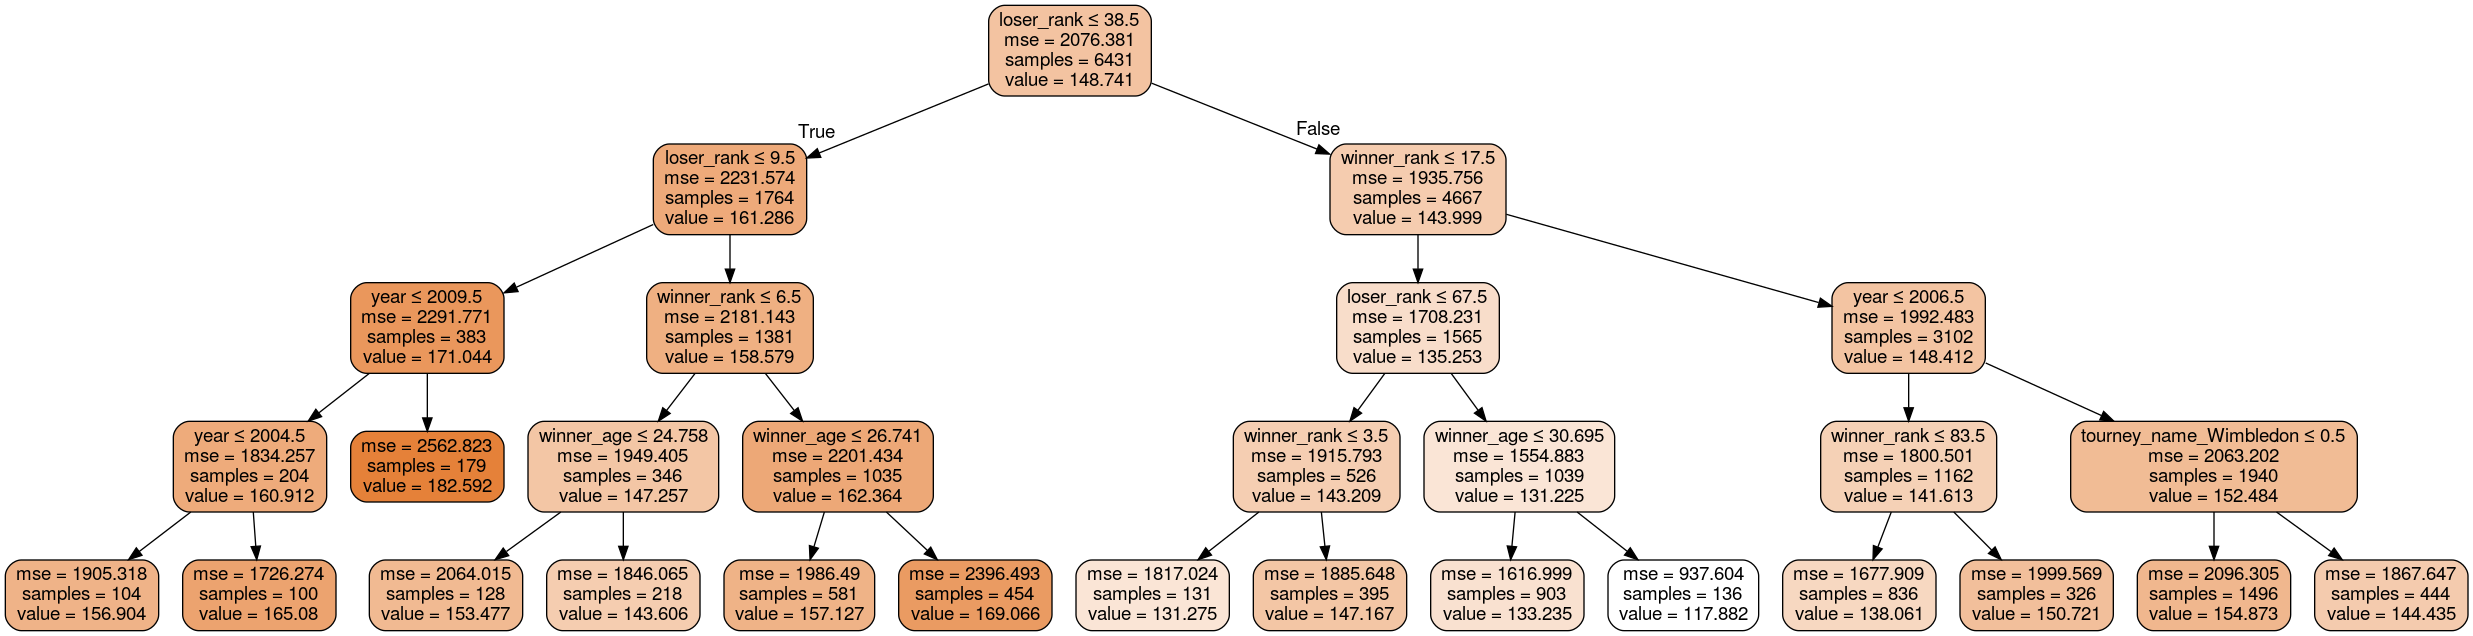

In [137]:
dot_data = StringIO()

export_graphviz(regBestTree_bo5, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
               feature_names=X_train_T_bo5.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

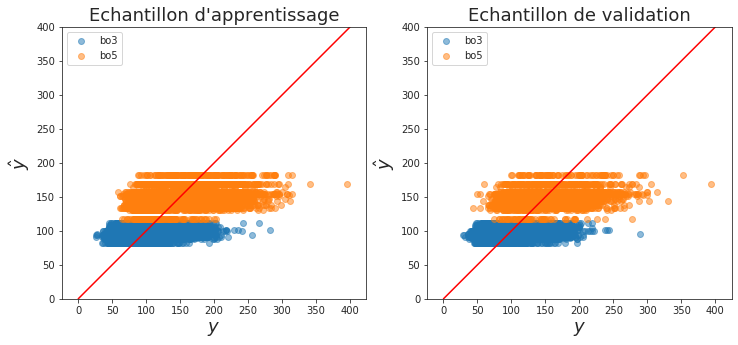

In [141]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].scatter(y_train_bo3, y_pred_train_bo3, alpha=0.5, label='bo3')
axs[0].scatter(y_train_bo5, y_pred_train_bo5, alpha=0.5, label='bo5')
axs[0].plot([0,400], [0,400], color='red')
axs[0].axis('equal')
axs[0].set_xlim((0,400))
axs[0].set_ylim((0,400))
axs[0].set_xlabel("$y$",fontsize=18)
axs[0].set_ylabel("$\hat{y}$",fontsize=18)
axs[0].legend()
axs[0].set_title("Echantillon d'apprentissage",fontsize=18)
axs[1].scatter(y_test_bo3, y_pred_test_bo3, alpha=0.5, label='bo3')
axs[1].scatter(y_test_bo5, y_pred_test_bo5, alpha=0.5, label='bo5')
axs[1].plot([0,400], [0,400], color='red')
axs[1].axis('equal')
axs[1].set_xlim((0,400))
axs[1].set_ylim((0,400))
axs[1].set_xlabel("$y$",fontsize=18)
axs[1].set_ylabel("$\hat{y}$",fontsize=18)
axs[1].legend()
axs[1].set_title("Echantillon de validation", fontsize=18)
plt.show()

## Random Forest

Nous passons maintenant aux Random Forests

In [142]:
from sklearn.ensemble import RandomForestRegressor

In [146]:
regRF_bo3 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1,)
regRF_bo5 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

RF_params = {'max_depth':[x for x in range(5,21,5)], 
                   'min_samples_leaf':[10, 100, 500],
              'max_features':['sqrt', 'log2', 'auto'],
              'bootstrap':[True, False]}

In [149]:
GSCV_RF_bo3 = GridSearchCV(regRF_bo3, RF_params, 'neg_mean_squared_error', cv=3)
GSCV_RF_bo3.fit(X_train_T_bo3, y_train_bo3)
regBestRF_bo3 = GSCV_RF_bo3.best_estimator_
print('Valeurs optimales de (max_depth, min_samples_leaf, max_features, bootstrap) : {}'.format((GSCV_RF_bo3.best_estimator_.get_params()['max_depth'], 
                                                                                               GSCV_RF_bo3.best_estimator_.get_params()['min_samples_leaf'], 
                                                                                               GSCV_RF_bo3.best_estimator_.get_params()['max_features'], 
                                                                                               GSCV_RF_bo3.best_estimator_.get_params()['bootstrap'])))
X_test_T_bo3 = harmonisation_train_test(X_train_T_bo3, X_test_T_bo3)
y_pred_train_bo3 = regBestRF_bo3.predict(X_train_T_bo3.values)
y_pred_test_bo3 = regBestRF_bo3.predict(X_test_T_bo3.values)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo3.values, y_pred_train_bo3),
                                                    mean_squared_error(y_test_bo3.values, y_pred_test_bo3)))

GSCV_RF_bo5 = GridSearchCV(regRF_bo5, RF_params, 'neg_mean_squared_error', cv=3)
GSCV_RF_bo5.fit(X_train_T_bo5, y_train_bo5)
regBestRF_bo5 = GSCV_RF_bo5.best_estimator_
print('Valeurs optimales de (max_depth, min_samples_leaf, max_features, bootstrap) : {}'.format((GSCV_RF_bo5.best_estimator_.get_params()['max_depth'], 
                                                                                               GSCV_RF_bo5.best_estimator_.get_params()['min_samples_leaf'], 
                                                                                               GSCV_RF_bo5.best_estimator_.get_params()['max_features'], 
                                                                                               GSCV_RF_bo5.best_estimator_.get_params()['bootstrap'])))
X_test_T_bo5 = harmonisation_train_test(X_train_T_bo5, X_test_T_bo5)
y_pred_train_bo5 = regBestRF_bo5.predict(X_train_T_bo5.values)
y_pred_test_bo5 = regBestRF_bo5.predict(X_test_T_bo5.values)
print('Bo5:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo5.values, y_pred_train_bo5),
                                                    mean_squared_error(y_test_bo5.values, y_pred_test_bo5)))

Valeurs optimales de (max_depth, min_samples_leaf, max_features, bootstrap) : (20, 10, 'sqrt', True)
Bo3:
	MSE : train = 800.7821528005641 / test = 874.0760464574996
Valeurs optimales de (max_depth, min_samples_leaf, max_features, bootstrap) : (5, 10, 'auto', True)
Bo3:
	MSE : train = 1826.964416294056 / test = 1955.110648461729


Ce modèle est jusqu'à maintenant le plus performant, que ce soit sur les matchs en bo3 ou les matchs en bo5, sur l'échantillon d'apprentissage et de validation.  
  
Les hyper paramètres optimaux sont indiqués dans la sortie Python.

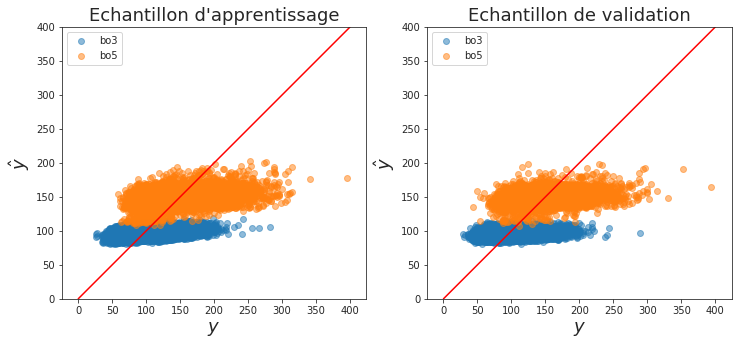

In [148]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].scatter(y_train_bo3, y_pred_train_bo3, alpha=0.5, label='bo3')
axs[0].scatter(y_train_bo5, y_pred_train_bo5, alpha=0.5, label='bo5')
axs[0].plot([0,400], [0,400], color='red')
axs[0].axis('equal')
axs[0].set_xlim((0,400))
axs[0].set_ylim((0,400))
axs[0].set_xlabel("$y$",fontsize=18)
axs[0].set_ylabel("$\hat{y}$",fontsize=18)
axs[0].legend()
axs[0].set_title("Echantillon d'apprentissage",fontsize=18)
axs[1].scatter(y_test_bo3, y_pred_test_bo3, alpha=0.5, label='bo3')
axs[1].scatter(y_test_bo5, y_pred_test_bo5, alpha=0.5, label='bo5')
axs[1].plot([0,400], [0,400], color='red')
axs[1].axis('equal')
axs[1].set_xlim((0,400))
axs[1].set_ylim((0,400))
axs[1].set_xlabel("$y$",fontsize=18)
axs[1].set_ylabel("$\hat{y}$",fontsize=18)
axs[1].legend()
axs[1].set_title("Echantillon de validation", fontsize=18)
plt.show()

## Adaboost

Le dernier modèle que nous employons est Adaboost, une algorithme de type ensemble learning (et plus exactement de la famille des Boosting Trees come XGBoost par exemple).  
  
Dans ce type de modèle, le nombre de weak learners utilisés est une variable de contrôle de l'overfit crucial directement lié au learning rate, plus le learning rate diminue, plus le nombre optimal d'estimateur est élevé. L'estiamteur de base que nous utiliserons reprendra les caractéristiques des arbres constituant les Random Forest précédantes.  
  
Pour optimiser les hypers paramètres d'Adaboost, nous commencons par fixer un learning rate élevé pour trouver le nombre optimal d'estimateurs sous ce learning rate. Puis nous essayeront différentes pertes avant de recommencer une CrossValidation avec cette fois-ci un learning rate plus faible du nombre d'estimateurs.  
  
Une fois cette optimisation faite, nous baisserons la valeur du learning rate et recommenceront à une dernière CrossValidation pour fixer le nombre final d'estimateur (tout autres hyperparamètres étant fixé aux optimum précédemment trouvés).  

In [151]:
from sklearn.ensemble import AdaBoostRegressor

In [158]:
base_estimator_bo3 = DecisionTreeRegressor(max_depth=20, min_samples_leaf=10, max_features='sqrt')
base_estimator_bo5 = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, max_features='auto')

regAda_bo3 = AdaBoostRegressor(base_estimator=base_estimator_bo3,
                               learning_rate=0.5,
                               random_state=42)
regAda_bo5 = AdaBoostRegressor(base_estimator=base_estimator_bo5,
                               learning_rate=0.5,
                               random_state=42)

Ada_params = {'n_estimators':[50, 100, 200]}

In [160]:
GSCV_Ada_bo3 = GridSearchCV(regAda_bo3, Ada_params, 'neg_mean_squared_error', cv=3)
GSCV_Ada_bo3.fit(X_train_T_bo3, y_train_bo3)
regBestAda_bo3 = GSCV_Ada_bo3.best_estimator_
print('Valeur optimale de n_estimators : {}'.format((GSCV_Ada_bo3.best_estimator_.get_params()['n_estimators'])))
X_test_T_bo3 = harmonisation_train_test(X_train_T_bo3, X_test_T_bo3)
y_pred_train_bo3 = regBestAda_bo3.predict(X_train_T_bo3.values)
y_pred_test_bo3 = regBestAda_bo3.predict(X_test_T_bo3.values)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo3.values, y_pred_train_bo3),
                                                    mean_squared_error(y_test_bo3.values, y_pred_test_bo3)))

GSCV_Ada_bo5 = GridSearchCV(regAda_bo5, Ada_params, 'neg_mean_squared_error', cv=3)
GSCV_Ada_bo5.fit(X_train_T_bo5, y_train_bo5)
regBestAda_bo5 = GSCV_Ada_bo5.best_estimator_
print('Valeur optimale de n_estimators : {}'.format((GSCV_Ada_bo5.best_estimator_.get_params()['n_estimators'])))
X_test_T_bo5 = harmonisation_train_test(X_train_T_bo5, X_test_T_bo5)
y_pred_train_bo5 = regBestAda_bo5.predict(X_train_T_bo5.values)
y_pred_test_bo5 = regBestAda_bo5.predict(X_test_T_bo5.values)
print('Bo5:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo5.values, y_pred_train_bo5),
                                                    mean_squared_error(y_test_bo5.values, y_pred_test_bo5)))

Valeur optimale de n_estimators : 50
Bo3:
	MSE : train = 823.266165209574 / test = 942.5526902199445
Valeur optimale de n_estimators : 50
Bo3:
	MSE : train = 2091.274951672251 / test = 2272.7470366323464


Les résultats obtenus sont moins bons qu'avec la random forest, le learning rate doit être trop élevé, nous reviendrons sur ces paramètres après avoir décidé de la meilleure fonction de perte à utiliser.

In [162]:
regAda_bo3 = AdaBoostRegressor(base_estimator=base_estimator_bo3,
                               n_estimators=50,
                               learning_rate=0.5,
                               random_state=42)
regAda_bo5 = AdaBoostRegressor(base_estimator=base_estimator_bo5,
                               n_estimators=50,
                               learning_rate=0.5,
                               random_state=42)

Ada_params = {'loss':['linear', 'square', 'exponential']}

In [163]:
GSCV_Ada_bo3 = GridSearchCV(regAda_bo3, Ada_params, 'neg_mean_squared_error', cv=3)
GSCV_Ada_bo3.fit(X_train_T_bo3, y_train_bo3)
regBestAda_bo3 = GSCV_Ada_bo3.best_estimator_
print('Valeur optimale de loss : {}'.format((GSCV_Ada_bo3.best_estimator_.get_params()['loss'])))
X_test_T_bo3 = harmonisation_train_test(X_train_T_bo3, X_test_T_bo3)
y_pred_train_bo3 = regBestAda_bo3.predict(X_train_T_bo3.values)
y_pred_test_bo3 = regBestAda_bo3.predict(X_test_T_bo3.values)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo3.values, y_pred_train_bo3),
                                                    mean_squared_error(y_test_bo3.values, y_pred_test_bo3)))

GSCV_Ada_bo5 = GridSearchCV(regAda_bo5, Ada_params, 'neg_mean_squared_error', cv=3)
GSCV_Ada_bo5.fit(X_train_T_bo5, y_train_bo5)
regBestAda_bo5 = GSCV_Ada_bo5.best_estimator_
print('Valeur optimale de loss : {}'.format((GSCV_Ada_bo5.best_estimator_.get_params()['loss'])))
X_test_T_bo5 = harmonisation_train_test(X_train_T_bo5, X_test_T_bo5)
y_pred_train_bo5 = regBestAda_bo5.predict(X_train_T_bo5.values)
y_pred_test_bo5 = regBestAda_bo5.predict(X_test_T_bo5.values)
print('Bo5:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo5.values, y_pred_train_bo5),
                                                    mean_squared_error(y_test_bo5.values, y_pred_test_bo5)))

Valeur optimale de loss : exponential
Bo3:
	MSE : train = 813.1461612382575 / test = 934.0319432187779
Valeur optimale de loss : exponential
Bo5:
	MSE : train = 2061.589298073355 / test = 2240.709856346225


La fonction de perte à prévilégier semble être la exponential loss function.  
  
En baissant le learning rate à 0.005 nous regardons si le nombre d'arbre opimal augmente.

In [169]:
base_estimator_bo3 = DecisionTreeRegressor(max_depth=20, min_samples_leaf=10, max_features='sqrt')
base_estimator_bo5 = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, max_features='auto')

regAda_bo3 = AdaBoostRegressor(base_estimator=base_estimator_bo3,
                               learning_rate=0.1,
                               loss='exponential',
                               random_state=42)
regAda_bo5 = AdaBoostRegressor(base_estimator=base_estimator_bo5,
                               learning_rate=0.005,
                               loss='exponential',
                               random_state=42)

Ada_params = {'n_estimators':[50, 100, 200]}

In [170]:
GSCV_Ada_bo3 = GridSearchCV(regAda_bo3, Ada_params, 'neg_mean_squared_error', cv=3)
GSCV_Ada_bo3.fit(X_train_T_bo3, y_train_bo3)
regBestAda_bo3 = GSCV_Ada_bo3.best_estimator_
print('Valeur optimale de n_estimators : {}'.format((GSCV_Ada_bo3.best_estimator_.get_params()['n_estimators'])))
X_test_T_bo3 = harmonisation_train_test(X_train_T_bo3, X_test_T_bo3)
y_pred_train_bo3 = regBestAda_bo3.predict(X_train_T_bo3.values)
y_pred_test_bo3 = regBestAda_bo3.predict(X_test_T_bo3.values)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo3.values, y_pred_train_bo3),
                                                    mean_squared_error(y_test_bo3.values, y_pred_test_bo3)))

GSCV_Ada_bo5 = GridSearchCV(regAda_bo5, Ada_params, 'neg_mean_squared_error', cv=3)
GSCV_Ada_bo5.fit(X_train_T_bo5, y_train_bo5)
regBestAda_bo5 = GSCV_Ada_bo5.best_estimator_
print('Valeur optimale de n_estimators : {}'.format((GSCV_Ada_bo5.best_estimator_.get_params()['n_estimators'])))
X_test_T_bo5 = harmonisation_train_test(X_train_T_bo5, X_test_T_bo5)
y_pred_train_bo5 = regBestAda_bo5.predict(X_train_T_bo5.values)
y_pred_test_bo5 = regBestAda_bo5.predict(X_test_T_bo5.values)
print('Bo5:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo5.values, y_pred_train_bo5),
                                                    mean_squared_error(y_test_bo5.values, y_pred_test_bo5)))

Valeur optimale de n_estimators : 50
Bo3:
	MSE : train = 800.7977830304281 / test = 883.715529062397
Valeur optimale de n_estimators : 200
Bo5:
	MSE : train = 1845.8589343107385 / test = 1962.413635822695


Le nombre optimal de weak learners reste à 50 pour le modèle prédisant les bo3 tandis qu'il passe à 200 pour les bo5.

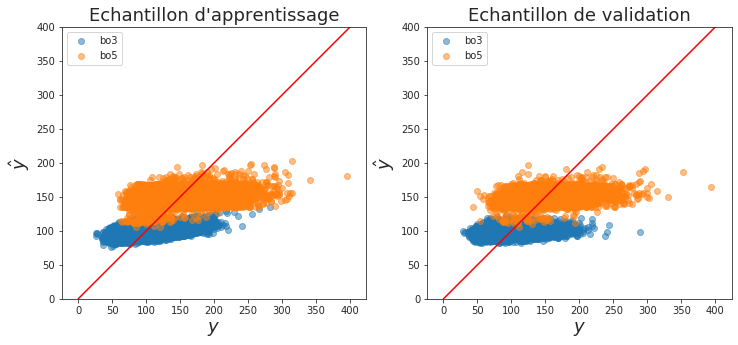

In [171]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].scatter(y_train_bo3, y_pred_train_bo3, alpha=0.5, label='bo3')
axs[0].scatter(y_train_bo5, y_pred_train_bo5, alpha=0.5, label='bo5')
axs[0].plot([0,400], [0,400], color='red')
axs[0].axis('equal')
axs[0].set_xlim((0,400))
axs[0].set_ylim((0,400))
axs[0].set_xlabel("$y$",fontsize=18)
axs[0].set_ylabel("$\hat{y}$",fontsize=18)
axs[0].legend()
axs[0].set_title("Echantillon d'apprentissage",fontsize=18)
axs[1].scatter(y_test_bo3, y_pred_test_bo3, alpha=0.5, label='bo3')
axs[1].scatter(y_test_bo5, y_pred_test_bo5, alpha=0.5, label='bo5')
axs[1].plot([0,400], [0,400], color='red')
axs[1].axis('equal')
axs[1].set_xlim((0,400))
axs[1].set_ylim((0,400))
axs[1].set_xlabel("$y$",fontsize=18)
axs[1].set_ylabel("$\hat{y}$",fontsize=18)
axs[1].legend()
axs[1].set_title("Echantillon de validation", fontsize=18)
plt.show()

# Récapitulatif des résultats

(Format : Train / Test)

| Modèle           | Bo3              | Bo5     |
| :---------------- |:----------------------:| :---------------:|
| Régression Linéaire     | $869$ / $885$ | $1976$ / $2052$ |
| Régression Lasso     | $869$ / $885$ | $1979$ / $2049$ |
| Régression Polynomiale| $817$ / $9.10^5$ | $1879$ / $9.10^9$ |
| Arbre de décision| $868$ / $887$ | $1917$ / $2002$ |
| Random Forest| $800$ / $874$ | $1826$ / $1955$ |
| Régression Polynomiale| $800$ / $883$ | $1845$ / $1962$ | 
  
C'est la Random Forest qui parmi tout nos modèle nous procure les meilleurs résultats